# Phase 2 - Ingestion and Cleaning

  - Ingest raw downloaded data
  - Output a combined dataset ready for analysis and modeling

In [2]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn
from collections import Counter

In [3]:
# A helper function to be used while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

## Parameters

In [4]:

dir_cs = r"C:/Users/sprih/OneDrive/Desktop/ML/MLPS/Case/case_study_data/1805_download/"

pickle_file = r"C:/Users/sprih/OneDrive/Desktop/ML/MLPS/Case/case_study_data/" + "clean_data.pickle" 

In [5]:
# Columns manually picked (as per faculty's guidance)
cols_to_pick = ["id","loan_amnt", "funded_amnt", "term", "int_rate", "installment", "grade", "emp_length",
"home_ownership", "annual_inc", "verification_status", "issue_d", "loan_status",
"purpose", "dti", "delinq_2yrs", "earliest_cr_line", "open_acc", "pub_rec",
"fico_range_high", "fico_range_low", "revol_bal","revol_util", "total_pymnt",
"last_pymnt_d", "recoveries"] 

# Identify the type of each of these columns -float/categorical/date/percentage
float_cols = ["loan_amnt","funded_amnt","installment","annual_inc","dti","open_acc","fico_range_high","fico_range_low","revol_bal","total_pymnt","recoveries"]
cat_cols = ["term","grade","emp_length","home_ownership","verification_status","loan_status","purpose","delinq_2yrs","pub_rec"] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']


In [6]:
# To ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [7]:
# Some of the columns selected will not be used directly in the model, but will be used to generate other features.

# All categorical columns other than "loan_status" will be used as discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## Ingestion
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [8]:
#A helper function provided by the instructors to assist with decompression of the multiple datasets 
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory+="/"
    
    all_files = os.listdir(directory) # get list of all files from the directory
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory+i,compression='zip',dtype='str',skiprows=1) 
        
       # df=output[i]
        invalid_rows = []
        invalid_rows = ~output[i]['id'].map(lambda test: is_integer(test))
        # Some of the files have "summary" lines that, for example read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs and remove them
       
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i]= output[i][~invalid_rows]
        
    
    return output # return dictionary of dataframe

In [9]:
# Ingest the set of files using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)

Directory C:/Users/sprih/OneDrive/Desktop/ML/MLPS/Case/case_study_data/1805_download/ has 12 files:
    Reading file LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file LoanStats3b_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3c_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q2.csv.zip
Found 2 invalid rows which were removed
    Readin

### Combine the files

In [10]:
data_cs = pd.concat([v for k,v in files_cs.items()]) # combine "files_cs" into a pandas dataframe

## Prepare Final Dataset

In [11]:
# Keep only the columns of interest from 'data_cs'
final_data = data_cs[cols_to_pick]

In [12]:
print("Starting with " + str(len(final_data)) + " rows")

Starting with 1765426 rows


In [ ]:
final_data.tail()

### Typecast the columns

In [14]:
# Typecast the columns based on feature types described above
for i in float_cols:
    final_data[i] = pd.to_numeric(final_data[i],errors='coerce') # typecast float columns

C:\Users\sprih\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    final_data[i] = pd.Series([clean_perc(ele) for ele in final_data[i]]) # apply clean_perc to percentage columns to remove any % signs

C:\Users\sprih\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    final_data[i] = pd.Series([clean_date(ele) for ele in final_data[i]]) # typecast date cloumns to datatime using clean_date

C:\Users\sprih\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
for i in cat_cols:
    final_data[i] = final_data[i].apply(lambda x: x if not pd.isnull(x) else None)# for categorical features if the value is null/empty set it to None

C:\Users\sprih\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Calculate returns for each loan

In [19]:
# Define the names of the four returns we'll be calculating as described in Q.6
# ret_PESS: Pessimistic return
# ret_OPT: Optimistic return
# ret_INTa, ret_INTb: Method3 at two differnt values of "i"
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb"]

In [20]:
# Remove all rows for loans that were paid back on the days(within 1 month) they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)

loanlength0 = []
loanlength0 = final_data['loan_length'].map(lambda test: test==0)

final_data = final_data[~loanlength0] # select rows where loan_length is not 0. 

print("Removed " + str(n_rows - len(final_data)) + " rows")

C:\Users\sprih\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Removed 80 rows


### M1-Pessimistic Method

In [49]:
# Calculate the return using a simple annualized profit margin - Pessimistic definition (M1)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int) # length of loan in months

final_data['ret_PESS'] = 1200*(final_data['total_pymnt']-final_data['funded_amnt'])/(final_data['funded_amnt']*final_data['term_num'])

### M2-Optimistic Method

In [50]:
# Assuming that if a loan gives a positive return(repaid with interest), we can immediately find a similar loan to invest in; if the loan
# takes a loss, we use M1-pessimistic to compute the return

final_data['ret_OPT'] = (final_data["total_pymnt"]-final_data["funded_amnt"])*1200/(final_data["funded_amnt"]*round(final_data['loan_length']))

final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = final_data.loc[final_data.ret_OPT < 0,'ret_PESS']

### Method 3

In [51]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal intervals during the duration of the loan, calculating 
    # the size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data['loan_length']

    # Assuming the amount is immediately re-invested at the prime rate, the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * (  (1-(1+i)**final_data['loan_length']) /(1-(1+i)) ) 
    
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate, with monthly re-investment, until T months from the 
    # start of the loan
    remaining_months = T - final_data['loan_length']
    final_return = (cash_by_end_of_loan * (i+1)** remaining_months)-final_data.funded_amnt
    ret_val = (1200/T) * final_return /final_data.funded_amnt
    return ret_val

In [52]:
k=np.where(final_data.total_pymnt == final_data.recoveries)
len(k[0])

1275

In [53]:
final_data['ret_INTa'] = ret_method_3(60,0.002) # call ret_method_3 with T=60, i=0.002
final_data['ret_INTb'] = ret_method_3(60,0.005) # call ret_method_3 with T=60, i=0.005

### Visualize the variables

In [54]:
def visualize_float_columns():
    '''
    This function visualizes Box-and-whisker plots for continuous variables
    '''
    for i in float_cols + perc_cols + ret_cols:
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        highest_vals=sorted(list(final_data[i].unique()), reverse=True)[:3]
        
        smallest_val = min(final_data[i])
        
        plt.text(smallest_val, -0.3, round(highest_vals[0],2))
        plt.text(smallest_val, -0.2, round(highest_vals[1],2))
        plt.text(smallest_val, -0.1, round(highest_vals[2],2))

        plt.show()

In [55]:
def visualize_cat_columns():
    '''
    Lists the distinct values for categorical columns
    '''
    for i in cat_cols:
        print('Field name: ',i) # print field name
        c= Counter( final_data[i])
        print('Number of distict values: ',len(c)) # print number of distinct values
        print(c) # for each distinct value print the number of occurances
        print("")
        print("")

In [56]:
def visualize_date_columns():
    '''
    This function visualizes a timeline density for dates
    '''
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

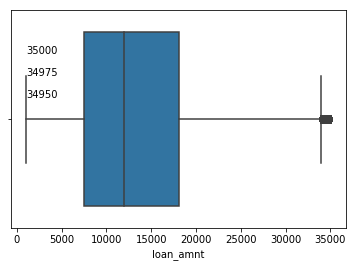

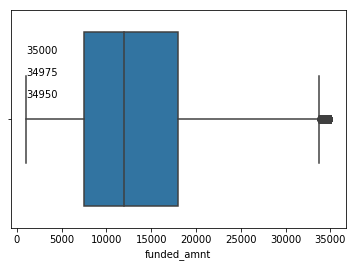

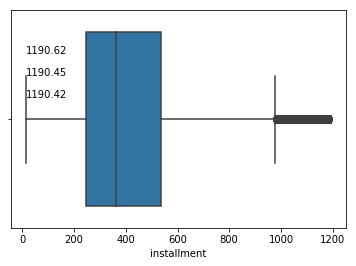

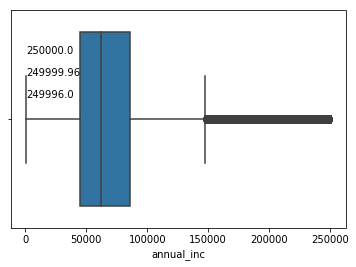

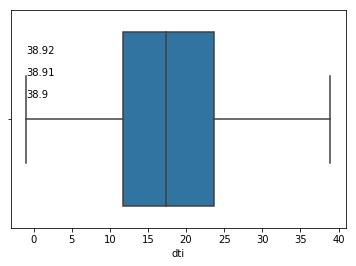

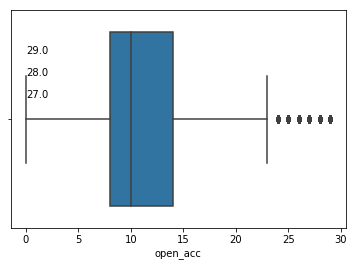

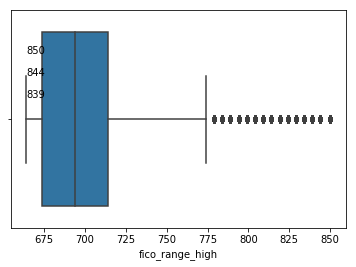

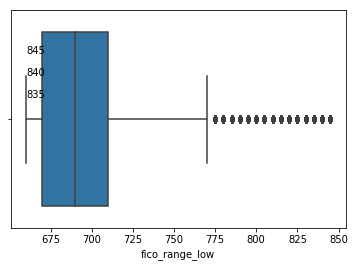

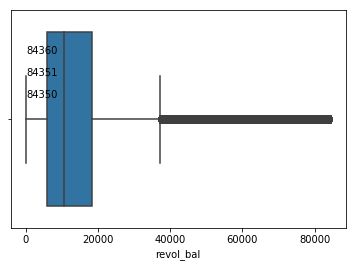

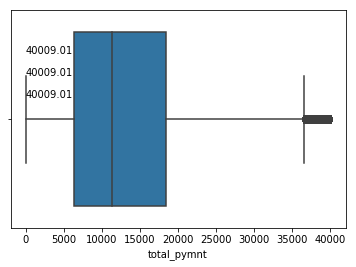

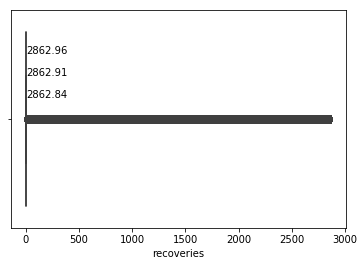

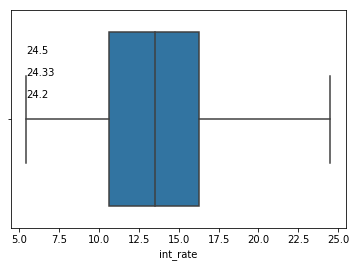

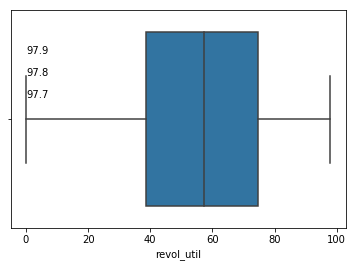

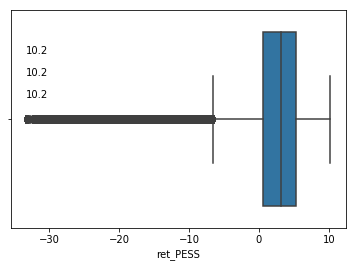

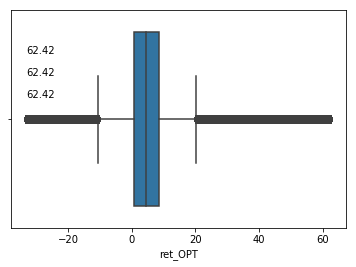

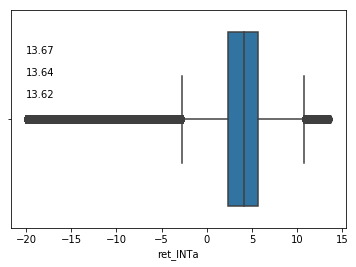

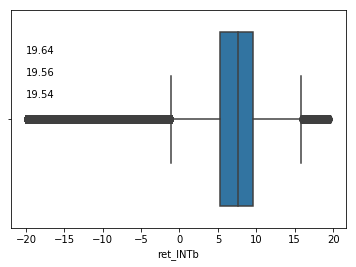

Field name:  term
Number of distict values:  2
Counter({' 36 months': 622417, ' 60 months': 185331})


Field name:  grade
Number of distict values:  7
Counter({'B': 244251, 'C': 231880, 'A': 140091, 'D': 117722, 'E': 51744, 'F': 17270, 'G': 4790})


Field name:  emp_length
Number of distict values:  12
Counter({'10+ years': 259056, '2 years': 73865, '3 years': 65167, '< 1 year': 64467, '1 year': 53604, '5 years': 51482, '4 years': 48837, None: 44582, '6 years': 39336, '8 years': 38121, '7 years': 37910, '9 years': 31321})


Field name:  home_ownership
Number of distict values:  6
Counter({'MORTGAGE': 392987, 'RENT': 331440, 'OWN': 83118, 'ANY': 131, 'OTHER': 41, 'NONE': 31})


Field name:  verification_status
Number of distict values:  3
Counter({'Source Verified': 300694, 'Not Verified': 260412, 'Verified': 246642})


Field name:  loan_status
Number of distict values:  8
Counter({'Fully Paid': 622237, 'Charged Off': 155024, 'Late (31-120 days)': 17385, 'In Grace Period': 7275, 'Late (

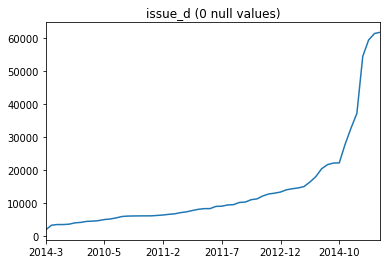

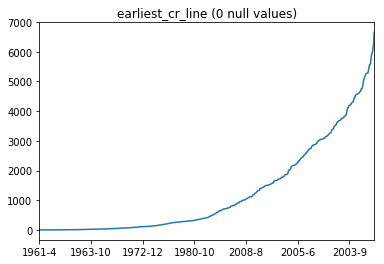

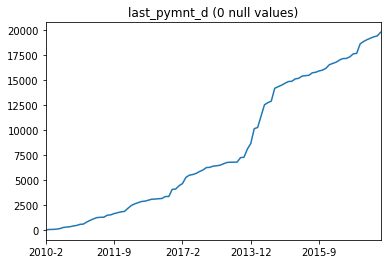

In [57]:
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

### Drop null values

In [58]:
# Deal with null values. Cateogrical variables to allowed to be null OTHER than grade, which is an important categorical.
# All non-categorical variables must be non-null, and we drop rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)

final_data.dropna(axis=0,subset= required_cols,inplace=True) # drop rows that contain null based only on "required_cols"

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 0 rows


### Handle outliers

In [59]:
# Removing outliers based on the visualization
n_rows = len(final_data)
cols_for_outliers=['loan_amnt','funded_amnt','installment','annual_inc','dti','open_acc','int_rate','total_pymnt','revol_bal','recoveries','revol_util','ret_OPT','ret_PESS']
n=n_rows
for i in cols_for_outliers:
    q = np.percentile(final_data[i],99)
    final_data=final_data[final_data[i] <= q]
    
print("Removed " + str(n_rows - len(final_data)) + " rows")
    
    
    
#     Q1 = temp[i].quantile(0.25)
#     Q3 = temp[i].quantile(0.75)
#     IQR = Q3 - Q1    #IQR is interquartile range. 
#     print(i,Q1,Q3,IQR,Q3 + 1.5 *IQR)
#     filter = (temp[i] <= Q3 + 1.5 *IQR)
#     #print(filter)
#     temp=temp.loc[filter]
#     print("Removed " + str(n - len(temp)) + " rows")
#     n=len(temp)
   
    
# print("Finally removed " + str(n_rows - len(temp)) + " rows")
    


Removed 79739 rows


In [60]:
# Remove all loans that are still current
n_rows = len(final_data)

currentloans = []
currentloans = final_data['loan_status'].map(lambda test: test == 'Current')
if currentloans.sum() > 0:
    print("Found " + str(currentloans.sum()) + " current loans which were removed")
    final_data= final_data[~currentloans]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 0 rows


In [61]:
# Only include loans isssued since 2010
n_rows = len(final_data)
#print(final_data['issue_d'])
final_data = final_data[final_data["issue_d"] >= datetime.date(2010, 1, 1)]
#final_data = final_data[final_data['issue_d']>=datetime.datetime.strptime('2010-01-01', "%Y-%m-%d").date()]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 0 rows


### Visualize clean data

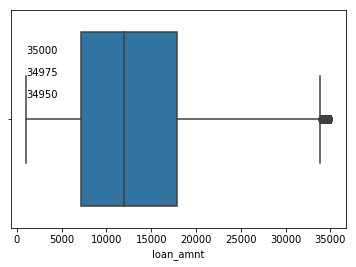

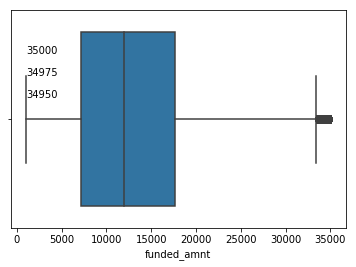

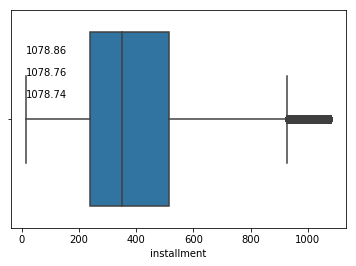

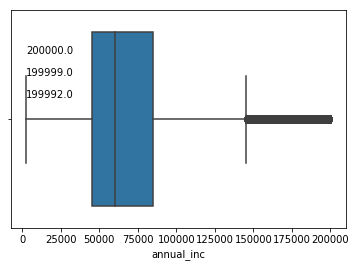

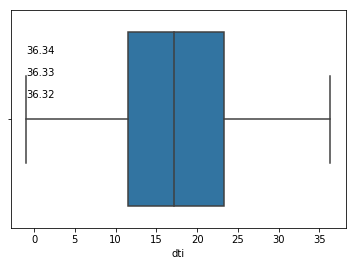

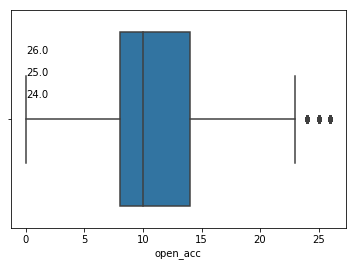

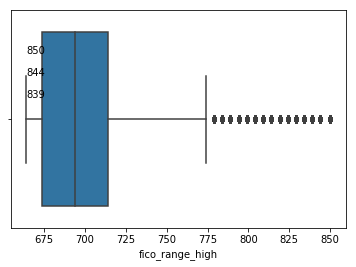

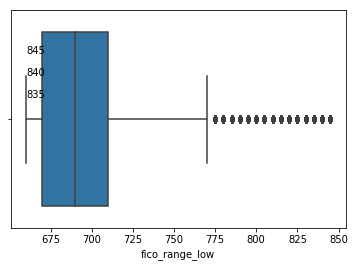

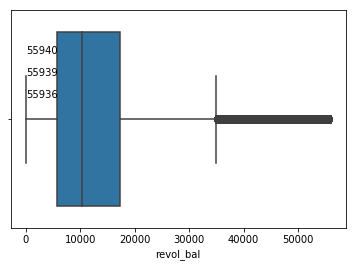

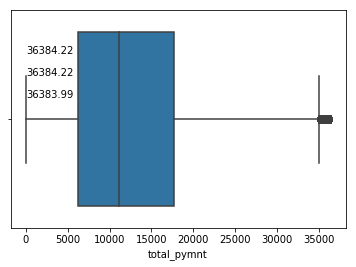

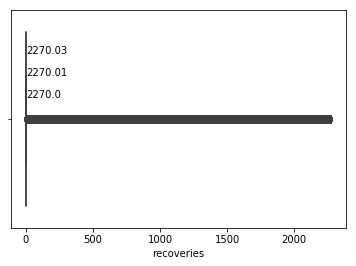

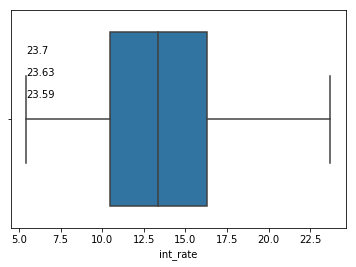

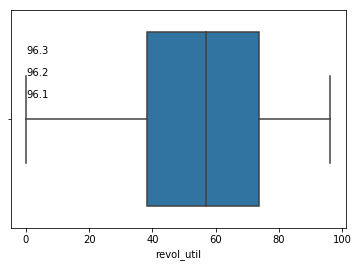

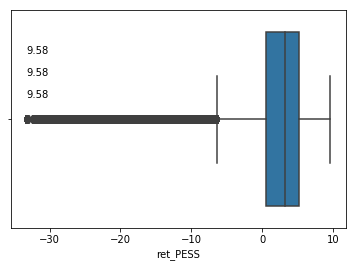

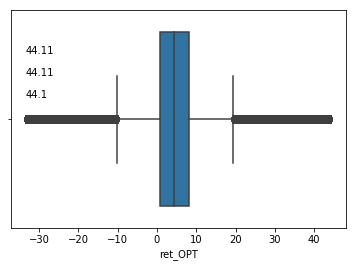

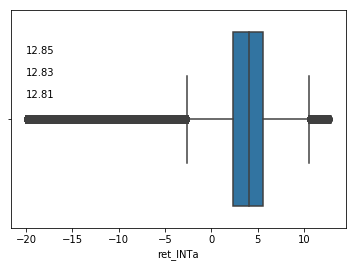

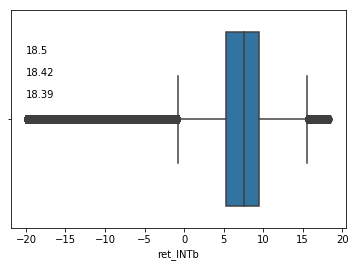

Field name:  term
Number of distict values:  2
Counter({' 36 months': 568754, ' 60 months': 159255})


Field name:  grade
Number of distict values:  7
Counter({'B': 226672, 'C': 210441, 'A': 130026, 'D': 99593, 'E': 43113, 'F': 14272, 'G': 3892})


Field name:  emp_length
Number of distict values:  12
Counter({'10+ years': 230394, '2 years': 67050, '3 years': 59186, '< 1 year': 58445, '1 year': 48623, '5 years': 46769, '4 years': 44353, None: 40880, '6 years': 35645, '8 years': 34288, '7 years': 34152, '9 years': 28224})


Field name:  home_ownership
Number of distict values:  6
Counter({'MORTGAGE': 349308, 'RENT': 303949, 'OWN': 74573, 'ANY': 112, 'OTHER': 40, 'NONE': 27})


Field name:  verification_status
Number of distict values:  3
Counter({'Source Verified': 270745, 'Not Verified': 242820, 'Verified': 214444})


Field name:  loan_status
Number of distict values:  8
Counter({'Fully Paid': 562922, 'Charged Off': 137201, 'Late (31-120 days)': 15953, 'In Grace Period': 6623, 'Late (1

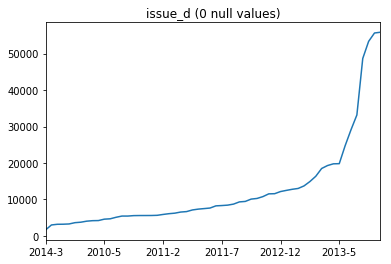

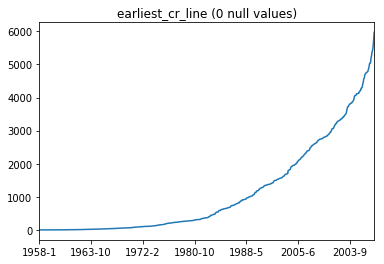

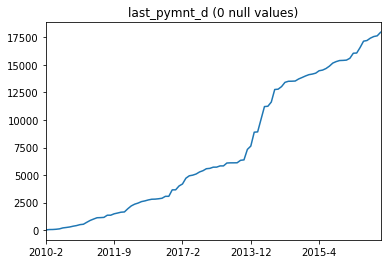

In [62]:
# Visualize the data again after cleaning

visualize_float_columns()

visualize_cat_columns()

visualize_date_columns()

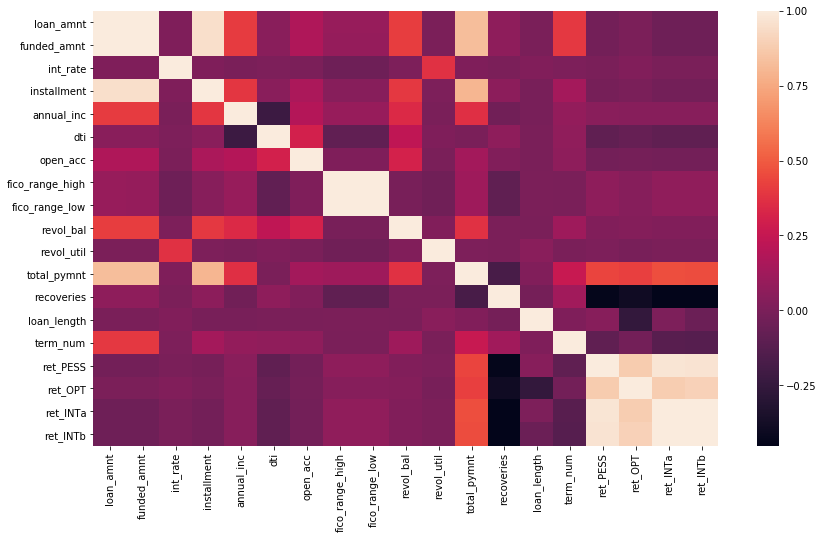

In [63]:
# Visualize the feature correlations

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14,8))  
correlation_matrix = final_data.corr()
seaborn.heatmap(correlation_matrix,xticklabels=correlation_matrix.columns,yticklabels=correlation_matrix.columns)

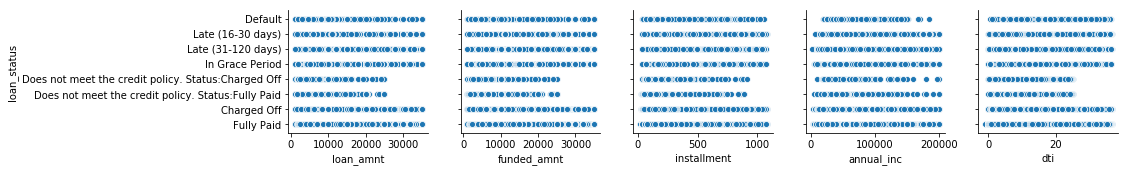

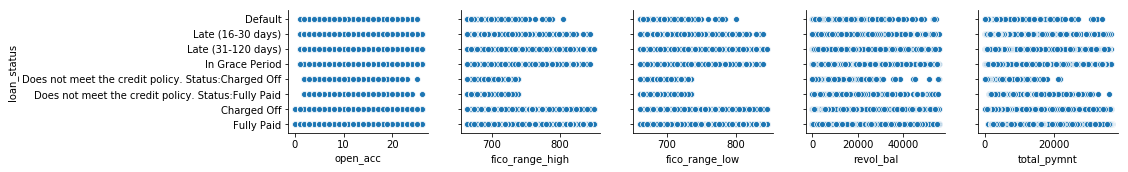

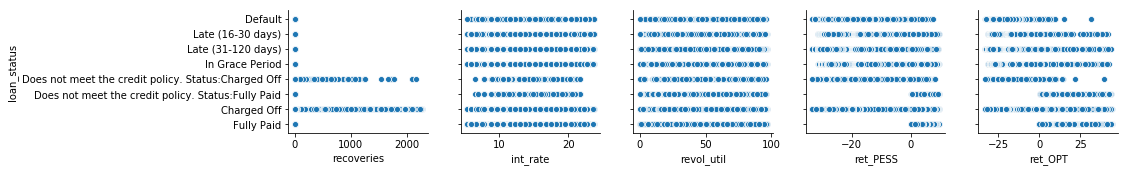

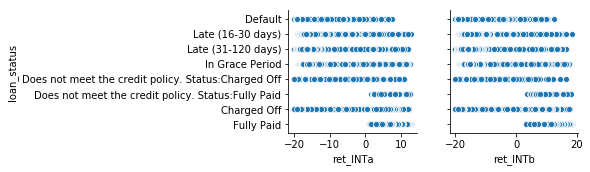

In [64]:
# Visualize relation between loan status and features

cols=float_cols + perc_cols + ret_cols
# for i,feature in enumerate(float_cols + perc_cols + ret_cols):
#     plt.figure(i)
#     seaborn.scatterplot(final_data[feature],final_data['loan_status'])
l=len(cols)
a=0
for i in range(l):
    if i==a:
        if l-i>=5:
            seaborn.pairplot(data=final_data, x_vars=cols[i:i+5], y_vars='loan_status')
            a+=5
        else:
            seaborn.pairplot(data=final_data, x_vars=cols[i:l], y_vars='loan_status')


### Data Exploration

In [65]:
# % of loans by grade, the default by grade, and the return for each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()

default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) ) #consider loans not fully paid 
ret_by_grade_OPT = final_data.groupby('grade')['ret_PESS'].mean()  # average return for M1-PessimistiM2-Optimistic for each loan grade
ret_by_grade_PESS = final_data.groupby('grade')['ret_OPT'].mean() # average return for M2-Optimistic for each loan grade
ret_by_grade_INTa = final_data.groupby('grade')['ret_INTa'].mean() # average return for M3
ret_by_grade_INTb = final_data.groupby('grade')['ret_INTb'].mean() # average return for M3
int_rate_by_grade = final_data.groupby('grade')['int_rate'].mean()

combined = pd.DataFrame(perc_by_grade)
combined.columns = ['perc_of_loans']
combined['perc_default'] = default_by_grade
combined['avg_int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb

combined

,perc_of_loans,perc_default,avg_int_rate,return_OPT,return_PESS,return_INTa,return_INTb
A,17.860493,7.167797,13.153116,1.523805,3.893571,2.928393,6.318654
B,31.135879,15.330522,13.503594,1.237115,4.172839,2.733579,6.075088
C,28.906373,25.468421,13.567168,0.009605,3.157924,1.829816,5.024166
D,13.680188,36.762624,13.636642,-1.621770,1.430381,0.548392,3.547977
E,5.922042,48.089903,13.696076,-3.479337,-0.498205,-1.182424,1.566179
F,1.960415,54.967769,13.768695,-4.520774,-1.662255,-2.381407,0.194741
G,0.534609,57.297020,13.637469,-5.684818,-3.244786,-3.562401,-1.155721


Observations:
1. High Return Rate ~ Safest Loans ~ Lowest Defaults
2. Interest Rates seems to be consistent across Grades (13-14%)


### Save a Pickle

In [66]:
# Remove the "total_pymnt" and "recoveries" from the list of continuous features
continuous_features.remove('total_pymnt')
continuous_features.remove('recoveries')

In [67]:
# save the prepared data for modeling in next Phase.
pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )